<a href="https://colab.research.google.com/github/Abigail6on/Apple-Health-Sleep-Analysis/blob/main/apple_health_hr_activity_sleep_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Apple Health Data: Exploring Sleep, Heart Rate, and Activity Patterns

## 1. Data Loading and initial inspection

Import all the packages for use.

In [8]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

Combine sleep data with heart rate data to analyze heart rate patterns during sleep.

In [9]:
records = []
for event, element in ET.iterparse('/content/export.xml', events=("start",)):
    if element.tag == "Record":
        records.append(element.attrib)

df = pd.DataFrame(records)

## 2. Data Cleaning and Preprocessing

In [10]:
print(df.shape)
print(df.columns)
print(df.dtypes)

(1048337, 9)
Index(['type', 'sourceName', 'sourceVersion', 'unit', 'creationDate',
       'startDate', 'endDate', 'value', 'device'],
      dtype='object')
type             object
sourceName       object
sourceVersion    object
unit             object
creationDate     object
startDate        object
endDate          object
value            object
device           object
dtype: object


In [11]:
# Convert dates to datetime
df['startDate'] = pd.to_datetime(df['startDate'], errors='coerce')
df['endDate'] = pd.to_datetime(df['endDate'], errors='coerce')

df['value_numeric'] = pd.to_numeric(df['value'], errors='coerce')

df = df.dropna(subset=['type', 'startDate', 'endDate'])
df = df.drop_duplicates()

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1048305 entries, 0 to 1048336
Data columns (total 10 columns):
 #   Column         Non-Null Count    Dtype                    
---  ------         --------------    -----                    
 0   type           1048305 non-null  object                   
 1   sourceName     1048305 non-null  object                   
 2   sourceVersion  1048156 non-null  object                   
 3   unit           1016944 non-null  object                   
 4   creationDate   1048305 non-null  object                   
 5   startDate      1048305 non-null  datetime64[ns, UTC-04:00]
 6   endDate        1048305 non-null  datetime64[ns, UTC-04:00]
 7   value          1048305 non-null  object                   
 8   device         840680 non-null   object                   
 9   value_numeric  1016944 non-null  float64                  
dtypes: datetime64[ns, UTC-04:00](2), float64(1), object(7)
memory usage: 88.0+ MB
None


In [12]:
# See most common record types
df['type'].value_counts().head(20)

,count
type,
HKQuantityTypeIdentifierHeartRate,175189
HKQuantityTypeIdentifierPhysicalEffort,162930
HKQuantityTypeIdentifierBasalEnergyBurned,154315
HKQuantityTypeIdentifierActiveEnergyBurned,150811
HKQuantityTypeIdentifierDistanceWalkingRunning,110721
HKQuantityTypeIdentifierStepCount,81053
HKQuantityTypeIdentifierEnvironmentalAudioExposure,21310
HKQuantityTypeIdentifierWalkingSpeed,20340
HKQuantityTypeIdentifierWalkingStepLength,20335


In [13]:
# 1. Heart rate data
hr_df = df[df['type'] == 'HKQuantityTypeIdentifierHeartRate'].copy()
hr_df['heart_rate'] = hr_df['value_numeric']
hr_df = hr_df.dropna(subset=['heart_rate'])

# 2. Sleep data
sleep_df = df[df['type'] == 'HKCategoryTypeIdentifierSleepAnalysis'].copy()
sleep_df = sleep_df[sleep_df['value'].str.contains('Asleep|1', na=False)]
sleep_df['duration_hr'] = (sleep_df['endDate'] - sleep_df['startDate']).dt.total_seconds() / 3600
# sleep_df.head()

## 3. Exploratory Data Analysis (EDA)

### Total Sleep Duration Per Night

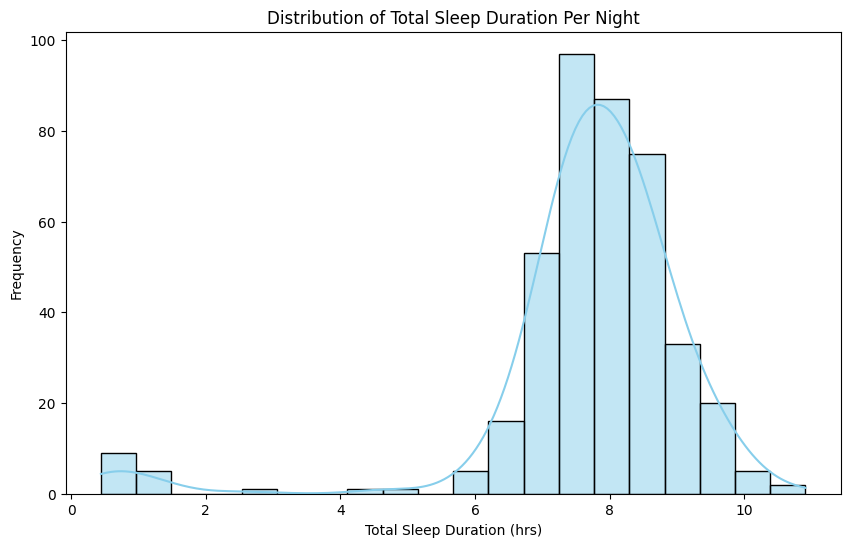

In [14]:
# Aggregate sleep duration by night
sleep_duration_per_night = sleep_df.groupby(sleep_df['startDate'].dt.date)['duration_hr'].sum().reset_index()
sleep_duration_per_night.rename(columns={'startDate': 'sleep_date', 'duration_hr': 'total_sleep_duration_hr'}, inplace=True)

# Visualize the distribution of total sleep duration per night
plt.figure(figsize=(10, 6))
sns.histplot(sleep_duration_per_night['total_sleep_duration_hr'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Total Sleep Duration Per Night')
plt.xlabel('Total Sleep Duration (hrs)')
plt.ylabel('Frequency')
plt.show()

# display(sleep_duration_per_night.head())

### Join Heart Rate During Sleep

In [15]:
# Create a list of HR records during sleep
sleep_hr_data = []

for _, sleep in sleep_df.iterrows():
    start = sleep['startDate']
    end = sleep['endDate']
    hr_during_sleep = hr_df[(hr_df['startDate'] >= start) & (hr_df['startDate'] <= end)].copy()
    if not hr_during_sleep.empty:
        hr_during_sleep['sleep_start'] = start
        hr_during_sleep['sleep_end'] = end
        sleep_hr_data.append(hr_during_sleep)

# Combine all
sleep_hr_df = pd.concat(sleep_hr_data) if sleep_hr_data else pd.DataFrame()
# sleep_hr_df.head()

### HR During Sleep

In [16]:
# Calculate the average heart rate for each sleep session
average_hr_per_sleep = sleep_hr_df.groupby('sleep_start')['heart_rate'].mean()

# Calculate the overall average heart rate during sleep
overall_average_sleep_hr = average_hr_per_sleep.mean()

print(f"The overall average heart rate during sleep across all recorded nights is: {overall_average_sleep_hr:.2f} bpm")

The overall average heart rate during sleep across all recorded nights is: 55.65 bpm


### Heart Rate Distribution During Sleep

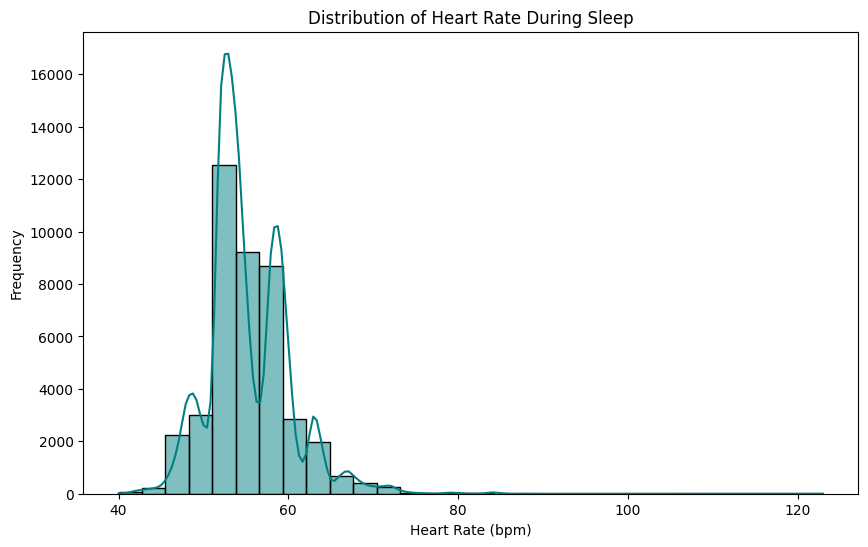

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(sleep_hr_df['heart_rate'], bins=30, kde=True, color='teal')
plt.title('Distribution of Heart Rate During Sleep')
plt.xlabel('Heart Rate (bpm)')
plt.ylabel('Frequency')
plt.show()

### Daily Minimum HR Trend (Line Plot)

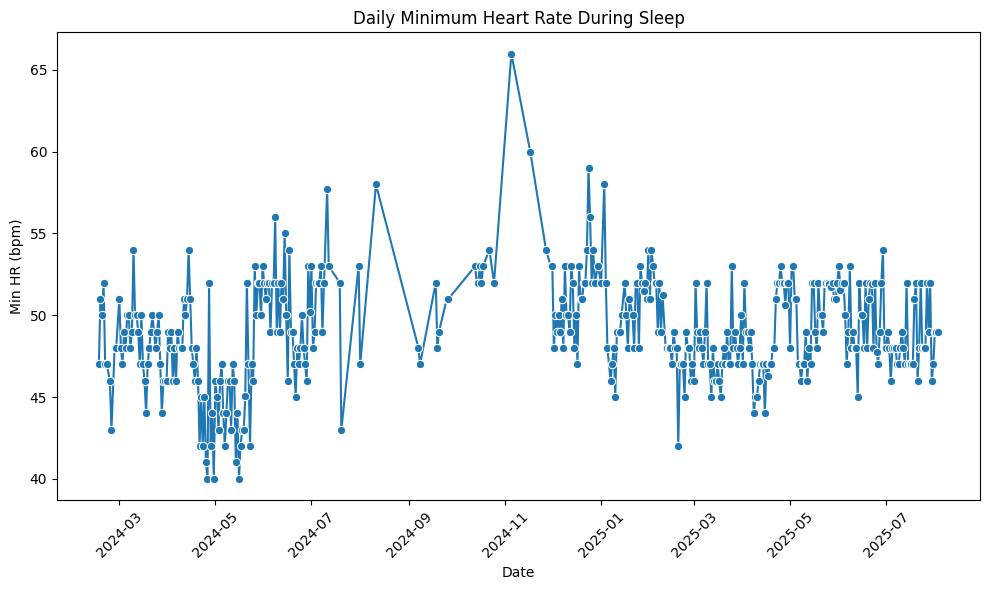

In [18]:
daily_min_hr = sleep_hr_df.groupby(sleep_hr_df['sleep_start'].dt.date)['heart_rate'].min().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='sleep_start', y='heart_rate', data=daily_min_hr, marker='o')
plt.title('Daily Minimum Heart Rate During Sleep')
plt.xlabel('Date')
plt.ylabel('Min HR (bpm)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Sleep Duration vs. Minimum HR (Scatter Plot)

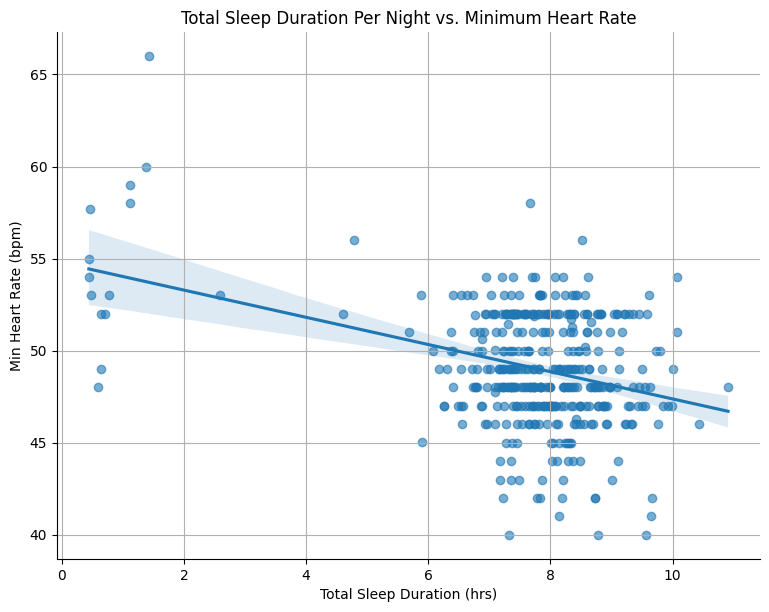

In [19]:
# Match HR to sleep sessions
sleep_summary = sleep_hr_df.groupby(sleep_hr_df['sleep_start'].dt.date)['heart_rate'].agg(['min', 'mean']).reset_index()
# Use the aggregated total sleep duration per night
sleep_duration = sleep_duration_per_night.rename(columns={'sleep_date': 'sleep_start'})
merged = pd.merge(sleep_summary, sleep_duration, on='sleep_start', how='inner')

sns.lmplot(data=merged, x='total_sleep_duration_hr', y='min', height=6, aspect=1.3, scatter_kws={'alpha': 0.6})
plt.title('Total Sleep Duration Per Night vs. Minimum Heart Rate')
plt.xlabel('Total Sleep Duration (hrs)')
plt.ylabel('Min Heart Rate (bpm)')
plt.grid(True)
plt.show()

### Boxplot of HR per Sleep Session

/tmp/ipython-input-2767825131.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  sleep_hr_df['sleep_week'] = sleep_hr_df['sleep_start'].dt.to_period('W').astype(str)


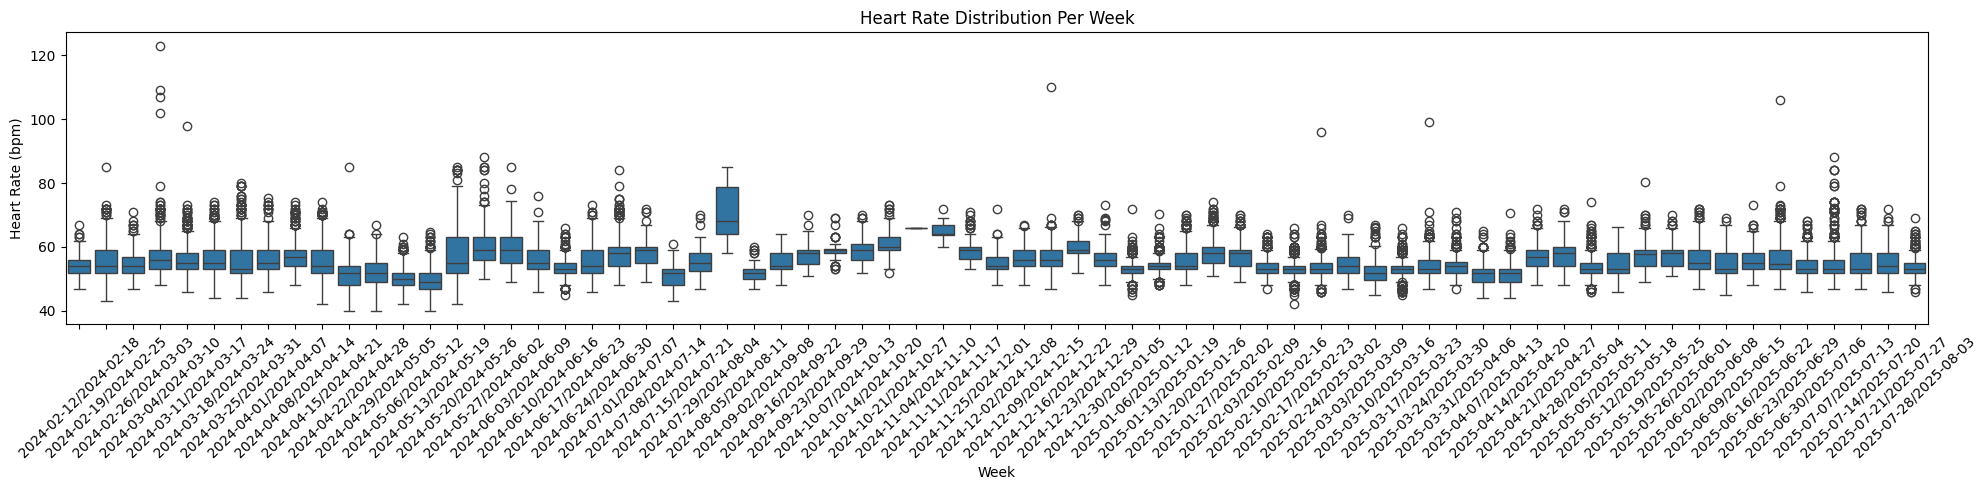

In [20]:
# Aggregate by Week Instead of Day
sleep_hr_df['sleep_week'] = sleep_hr_df['sleep_start'].dt.to_period('W').astype(str)

plt.figure(figsize=(20, 5))
sns.boxplot(x='sleep_week', y='heart_rate', data=sleep_hr_df)

plt.xticks(rotation=45)
plt.title('Heart Rate Distribution Per Week')
plt.xlabel('Week')
plt.ylabel('Heart Rate (bpm)')
plt.tight_layout()
plt.show()

Aggregate by Week Instead of Day

/tmp/ipython-input-2722546085.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  sleep_hr_df['sleep_week'] = sleep_hr_df['sleep_start'].dt.to_period('W').astype(str)


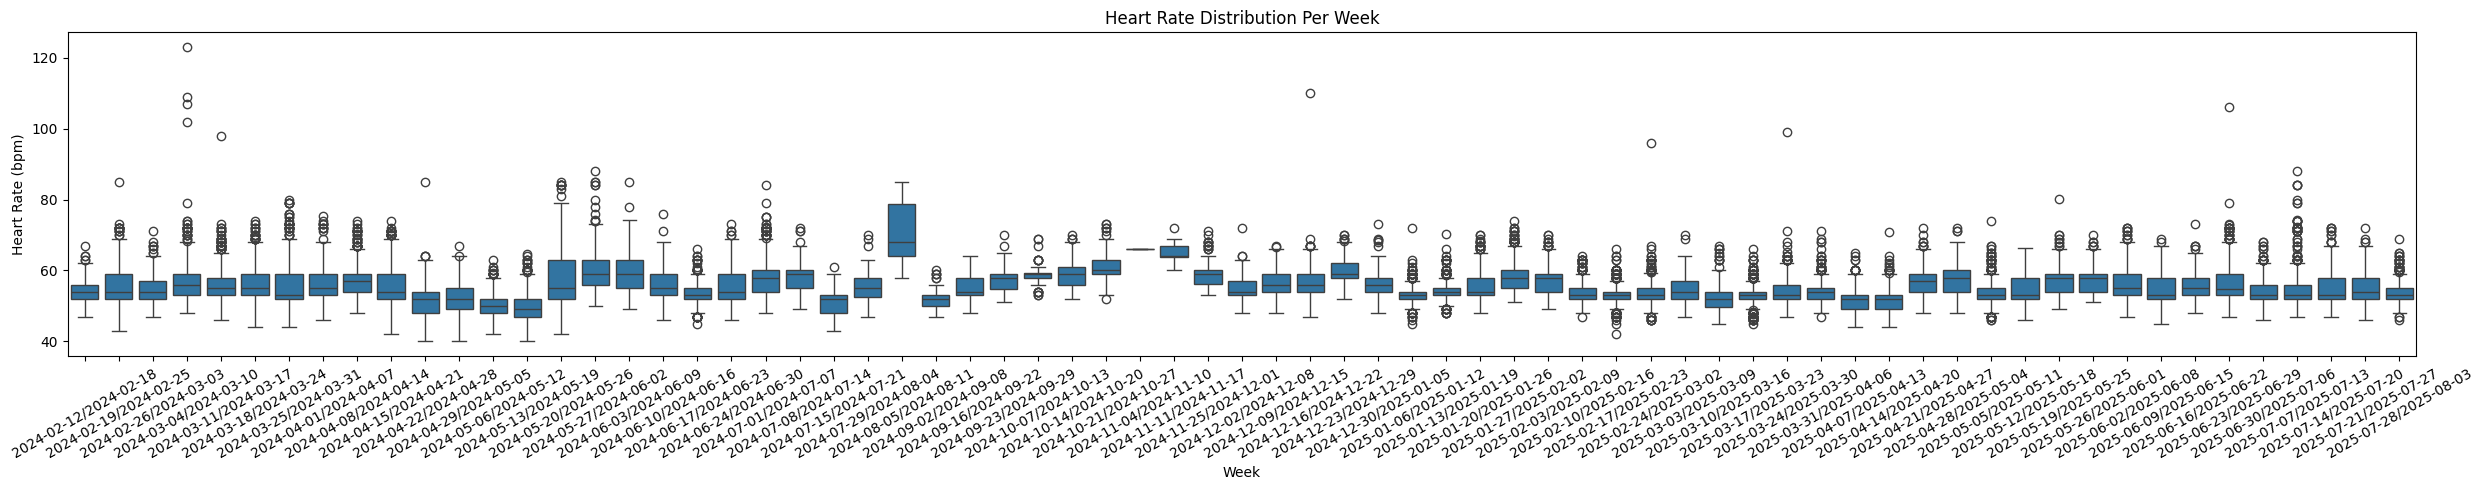

In [21]:
sleep_hr_df['sleep_week'] = sleep_hr_df['sleep_start'].dt.to_period('W').astype(str)

plt.figure(figsize=(25, 5))
sns.boxplot(x='sleep_week', y='heart_rate', data=sleep_hr_df)

plt.xticks(rotation=30)
plt.title('Heart Rate Distribution Per Week')
plt.xlabel('Week')
plt.ylabel('Heart Rate (bpm)')
plt.tight_layout()
plt.show()

### Violin Plot for Visualizing HR Distribution Patterns

Aggregate by Week (Reduce Category Count)

/tmp/ipython-input-1811399390.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  sleep_hr_df['sleep_week'] = sleep_hr_df['sleep_start'].dt.to_period('W').astype(str)


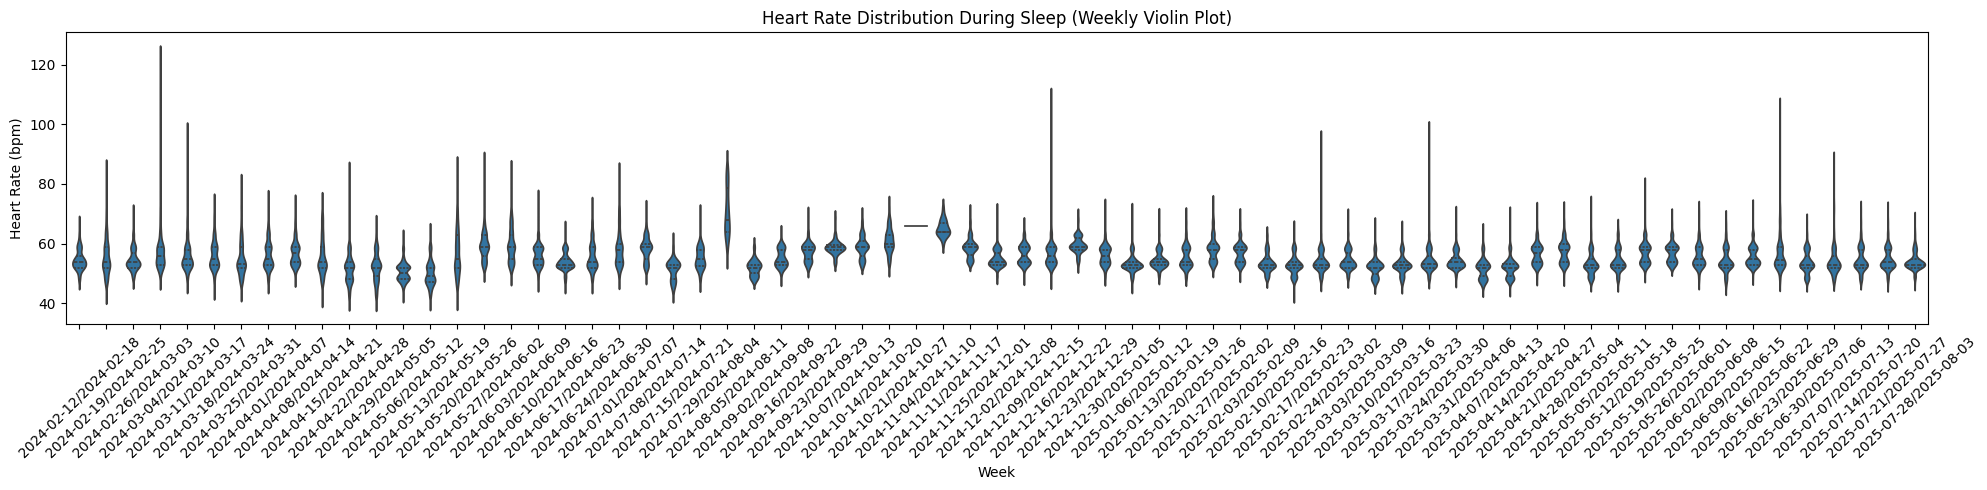

In [22]:
# Create a weekly column
sleep_hr_df['sleep_week'] = sleep_hr_df['sleep_start'].dt.to_period('W').astype(str)

plt.figure(figsize=(20, 5))
sns.violinplot(x='sleep_week', y='heart_rate', data=sleep_hr_df, inner='quartile')

plt.xticks(rotation=45)
plt.title('Heart Rate Distribution During Sleep (Weekly Violin Plot)')
plt.xlabel('Week')
plt.ylabel('Heart Rate (bpm)')
plt.tight_layout()
plt.show()

### Heatmap: HR by Hour of Night and Date

/tmp/ipython-input-3071528421.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pivot = pivot.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


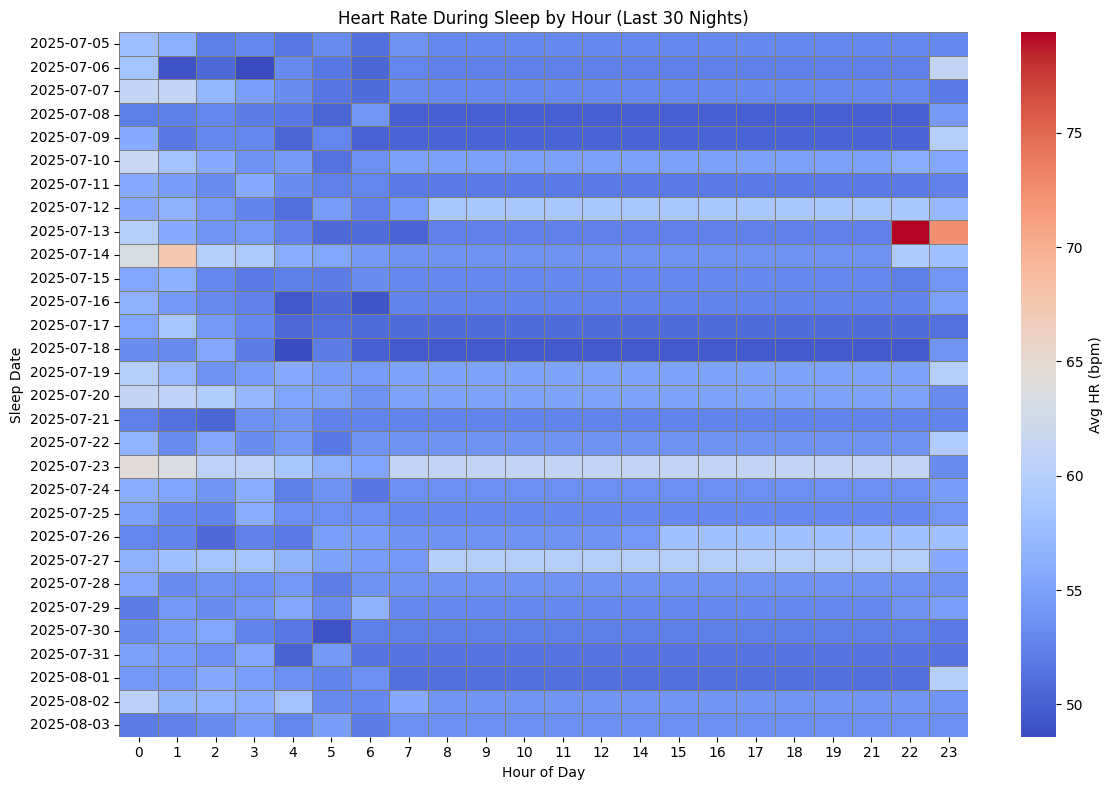

In [23]:
# Ensure required columns exist
sleep_hr_df['sleep_date'] = sleep_hr_df['sleep_start'].dt.date
sleep_hr_df['hour'] = sleep_hr_df['startDate'].dt.hour

# Create pivot table
pivot = sleep_hr_df.pivot_table(
    index='sleep_date',
    columns='hour',
    values='heart_rate',
    aggfunc='mean'
)

# limit to last 30 nights for readability
pivot = pivot.sort_index().tail(30)

# fill NaNs for better coloring (or keep as-is)
pivot = pivot.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot, cmap='coolwarm', cbar_kws={'label': 'Avg HR (bpm)'}, linewidths=0.5, linecolor='gray')

plt.title('Heart Rate During Sleep by Hour (Last 30 Nights)')
plt.xlabel('Hour of Day')
plt.ylabel('Sleep Date')
plt.tight_layout()
plt.show()

## 5. Create daily summary from `df`

In [24]:
df['startDate'] = pd.to_datetime(df['startDate'], errors='coerce')

# Create a 'date' column
df['date'] = df['startDate'].dt.date

df['value_numeric'] = pd.to_numeric(df['value'], errors='coerce')

# Pivot: get one row per day, one column per record type
daily_df = df.pivot_table(
    index='date',
    columns='type',
    values='value_numeric',
    aggfunc='mean'
)

In [25]:
corr = daily_df.corr()

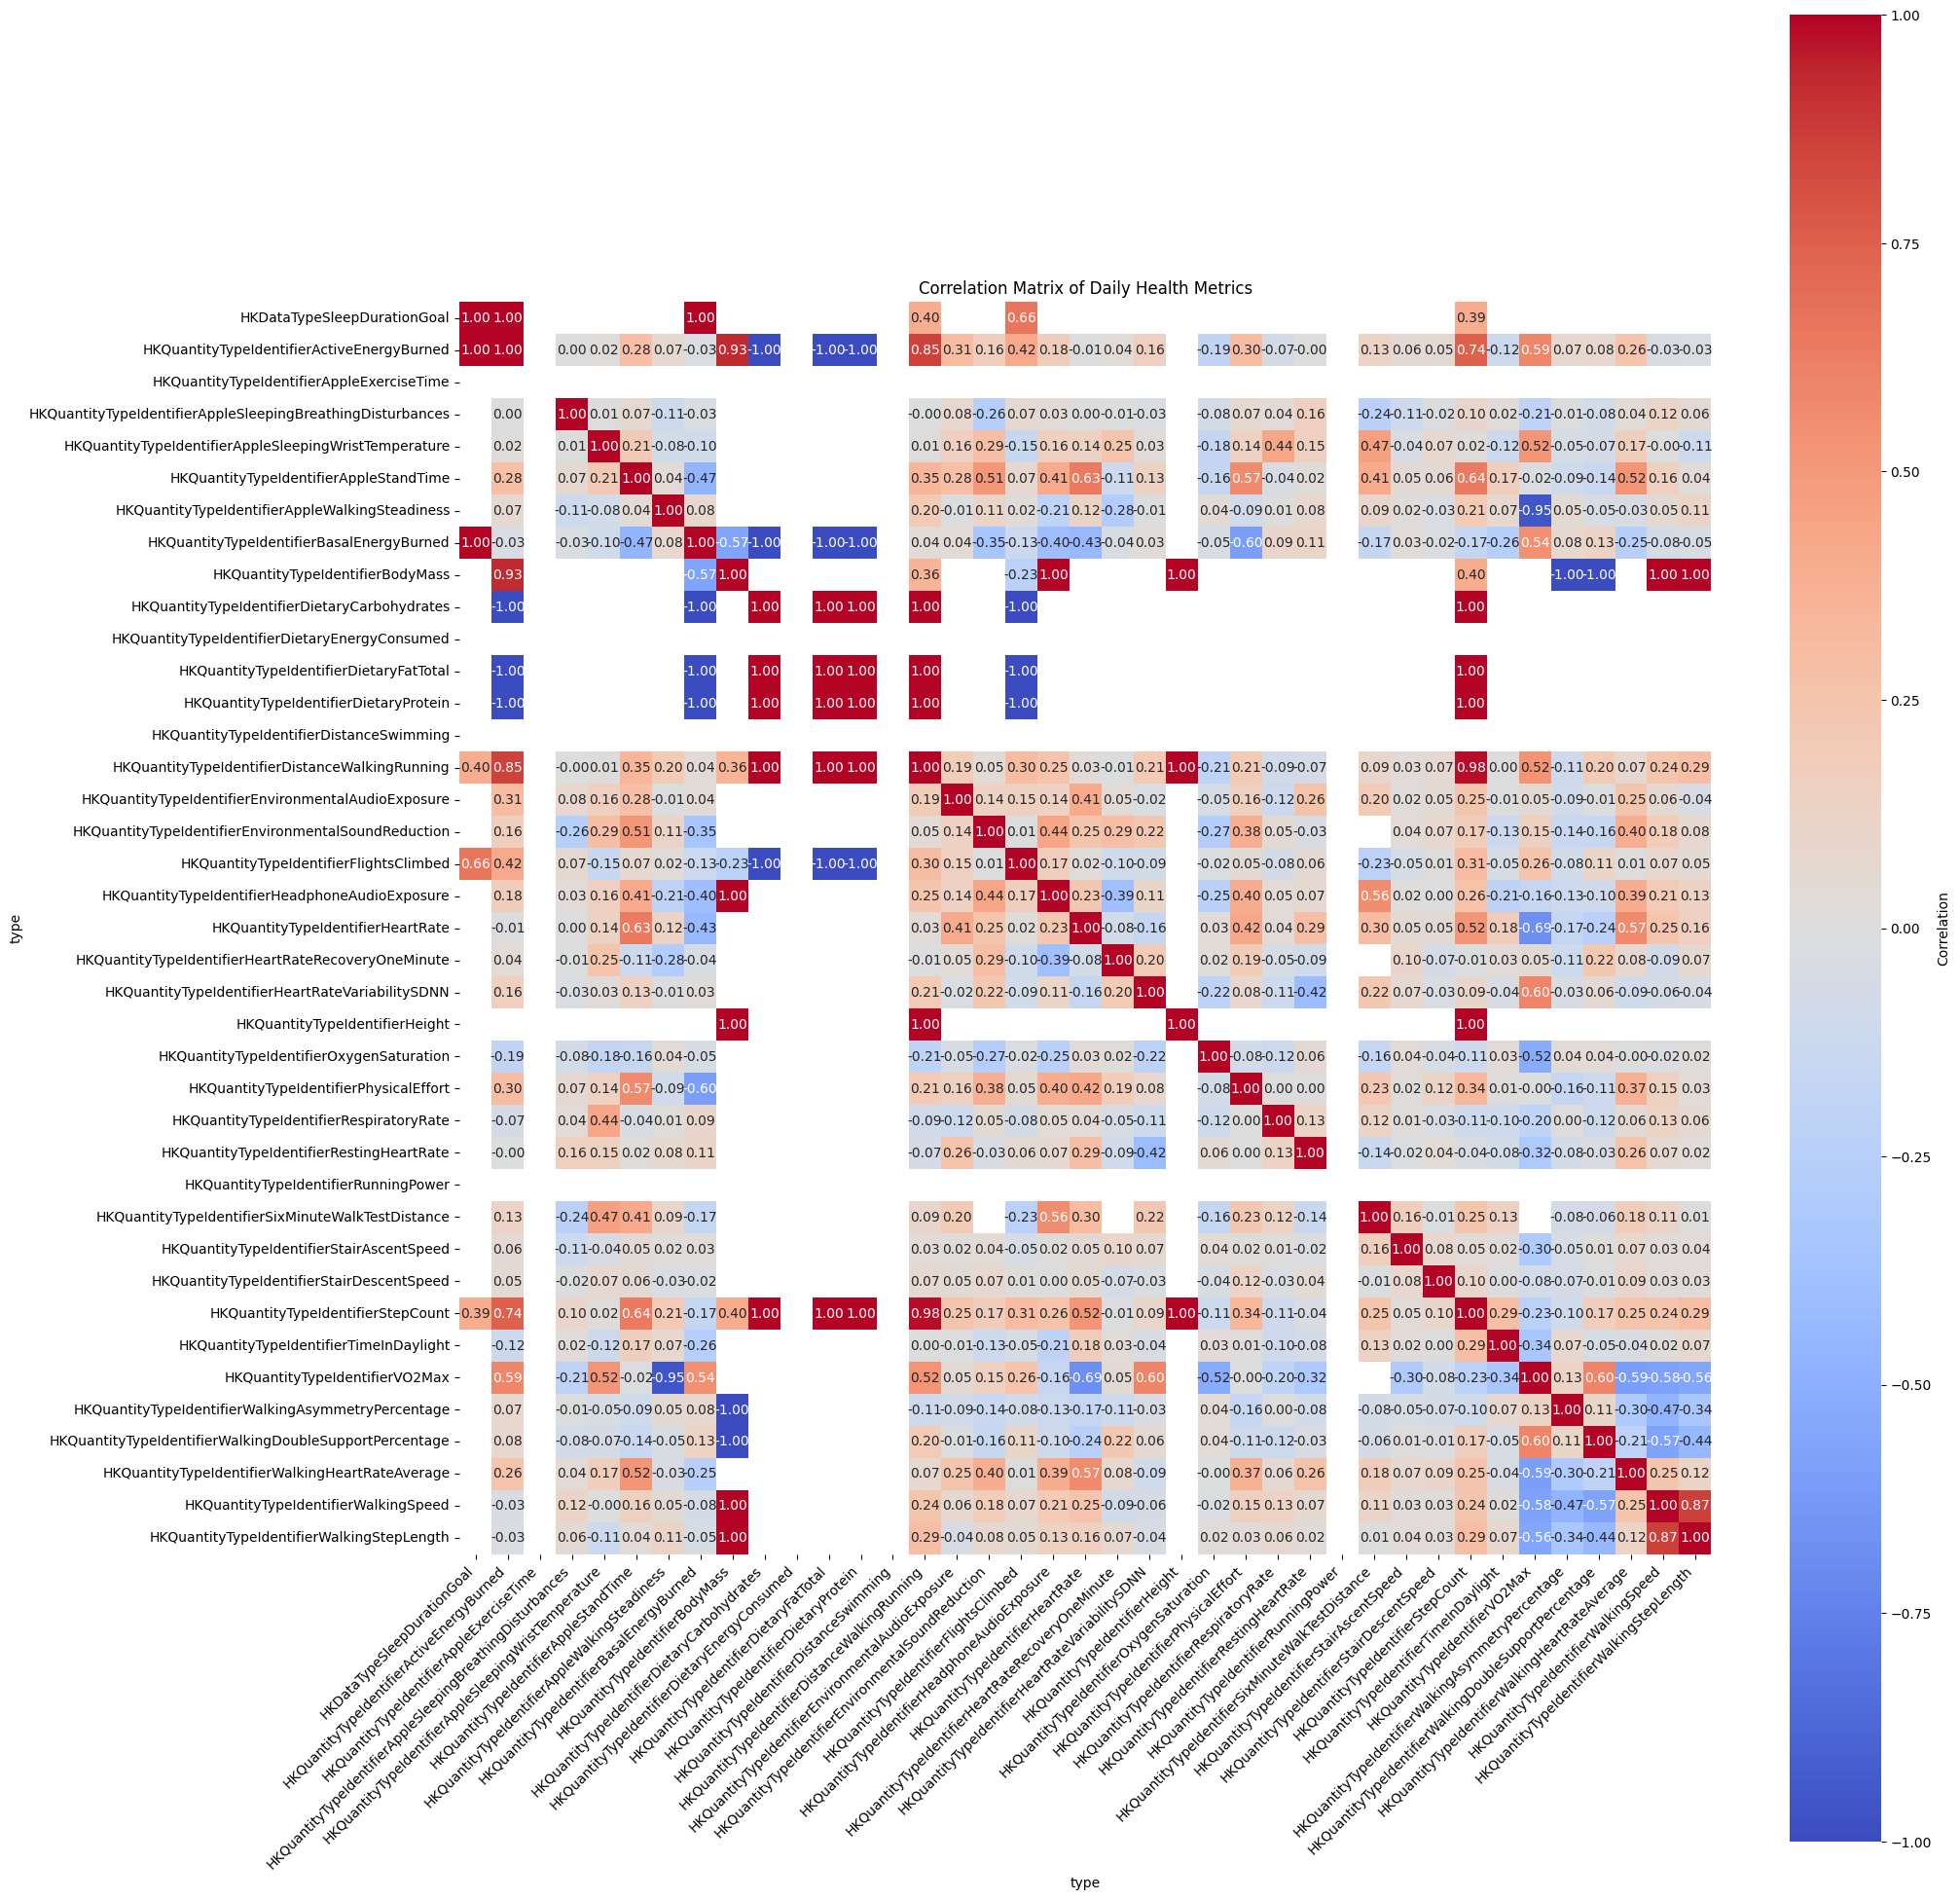

In [26]:
plt.figure(figsize=(21, 21))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={'label': 'Correlation'})
plt.title('Correlation Matrix of Daily Health Metrics')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### 1. Step Count vs. Distance Walking/Running

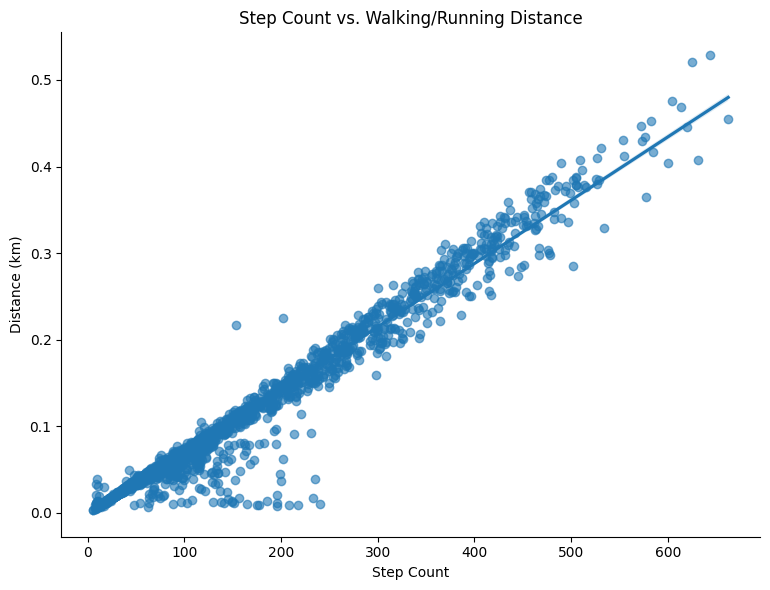

In [27]:
sns.lmplot(
    data=daily_df,
    x='HKQuantityTypeIdentifierStepCount',
    y='HKQuantityTypeIdentifierDistanceWalkingRunning',
    height=6, aspect=1.3,
    scatter_kws={'alpha': 0.6}
)
plt.title('Step Count vs. Walking/Running Distance')
plt.xlabel('Step Count')
plt.ylabel('Distance (km)')
plt.tight_layout()
plt.show()

### 2. Step Count vs. Active Energy Burned

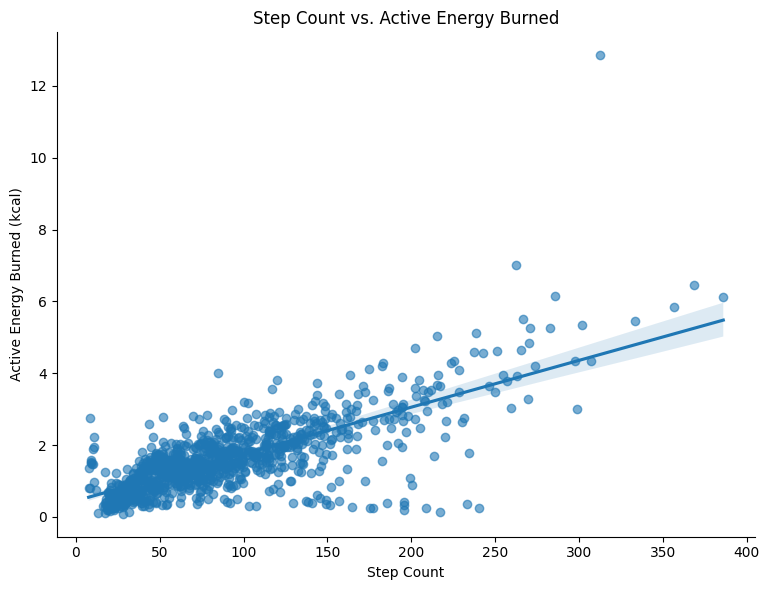

In [28]:
sns.lmplot(
    data=daily_df,
    x='HKQuantityTypeIdentifierStepCount',
    y='HKQuantityTypeIdentifierActiveEnergyBurned',
    height=6, aspect=1.3,
    scatter_kws={'alpha': 0.6}
)
plt.title('Step Count vs. Active Energy Burned')
plt.xlabel('Step Count')
plt.ylabel('Active Energy Burned (kcal)')
plt.tight_layout()
plt.show()

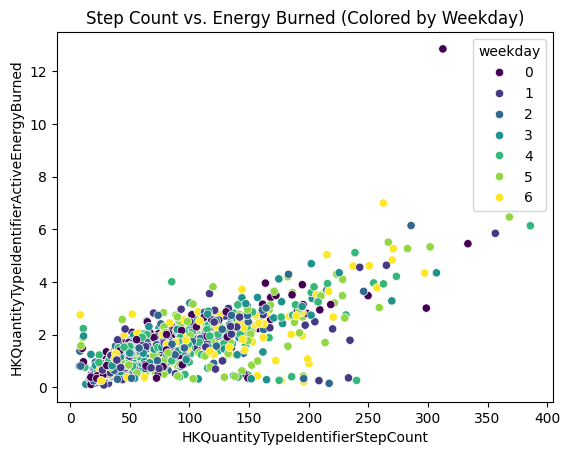

In [29]:
daily_df['weekday'] = pd.to_datetime(daily_df.index).weekday  # 0 = Monday
sns.scatterplot(
    data=daily_df,
    x='HKQuantityTypeIdentifierStepCount',
    y='HKQuantityTypeIdentifierActiveEnergyBurned',
    hue='weekday',
    palette='viridis'
)
plt.title('Step Count vs. Energy Burned (Colored by Weekday)')
plt.show()

### 3. Distance Walking/Running vs. Active Energy Burned


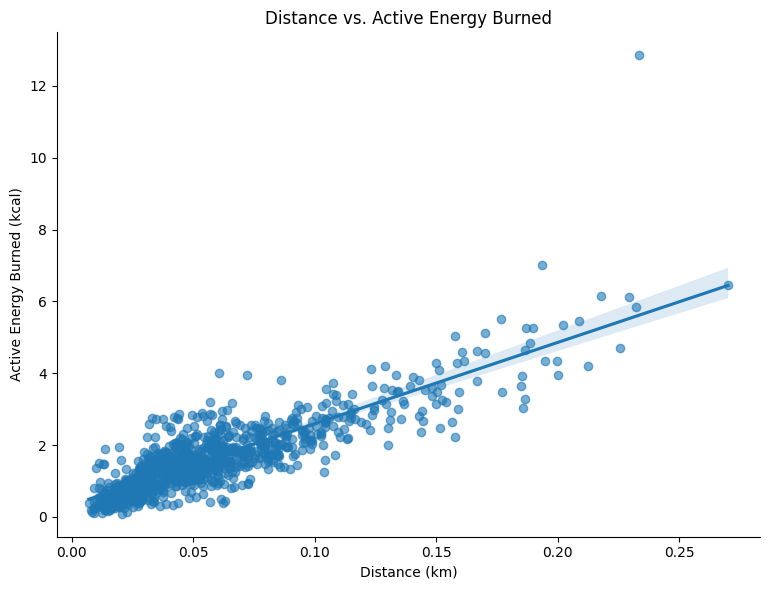

In [30]:
sns.lmplot(
    data=daily_df,
    x='HKQuantityTypeIdentifierDistanceWalkingRunning',
    y='HKQuantityTypeIdentifierActiveEnergyBurned',
    height=6, aspect=1.3,
    scatter_kws={'alpha': 0.6}
)
plt.title('Distance vs. Active Energy Burned')
plt.xlabel('Distance (km)')
plt.ylabel('Active Energy Burned (kcal)')
plt.tight_layout()
plt.show()

### 4. Walking Speed vs. Step Length

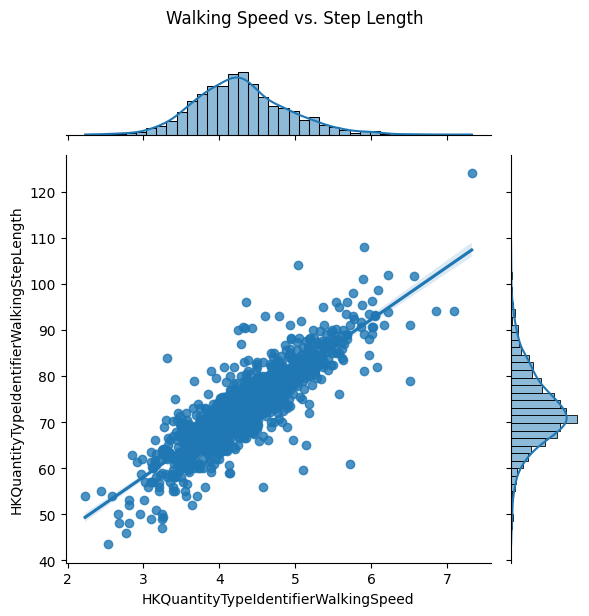

In [31]:
sns.jointplot(
    data=daily_df,
    x='HKQuantityTypeIdentifierWalkingSpeed',
    y='HKQuantityTypeIdentifierWalkingStepLength',
    kind='reg',
    height=6
)
plt.suptitle('Walking Speed vs. Step Length', y=1.02)
plt.tight_layout()
plt.show()

### 5.  Heart Rate vs. Physical Effort

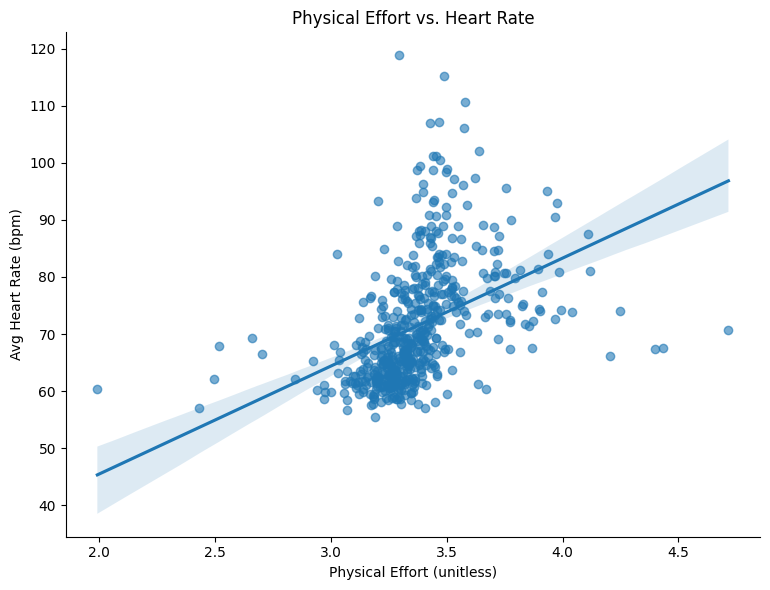

In [32]:
sns.lmplot(
    data=daily_df,
    x='HKQuantityTypeIdentifierPhysicalEffort',
    y='HKQuantityTypeIdentifierHeartRate',
    height=6, aspect=1.3,
    scatter_kws={'alpha': 0.6}
)
plt.title('Physical Effort vs. Heart Rate')
plt.xlabel('Physical Effort (unitless)')
plt.ylabel('Avg Heart Rate (bpm)')
plt.tight_layout()
plt.show()

## 6. Model Building

### Try a Simple Model — Linear Regression

In [33]:
# Drop rows with missing target or features
model_df = daily_df.copy()
model_df = model_df.dropna(subset=[
    'HKQuantityTypeIdentifierActiveEnergyBurned',
    'HKQuantityTypeIdentifierStepCount',
    'HKQuantityTypeIdentifierDistanceWalkingRunning',
    'HKQuantityTypeIdentifierHeartRate',
    'HKQuantityTypeIdentifierWalkingSpeed'
])

# Features and target
X = model_df[[
    'HKQuantityTypeIdentifierStepCount',
    'HKQuantityTypeIdentifierDistanceWalkingRunning',
    'HKQuantityTypeIdentifierHeartRate',
    'HKQuantityTypeIdentifierWalkingSpeed'
]]
y = model_df['HKQuantityTypeIdentifierActiveEnergyBurned']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [34]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

MAE: 0.3432314969553401
R² Score: 0.411290785324292


### Try a Tree-Based Model — Random Forest

In [35]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest MAE:", mean_absolute_error(y_test, y_pred_rf))
print("Random Forest R²:", r2_score(y_test, y_pred_rf))

Random Forest MAE: 0.30102505306184707
Random Forest R²: 0.5057921233270192


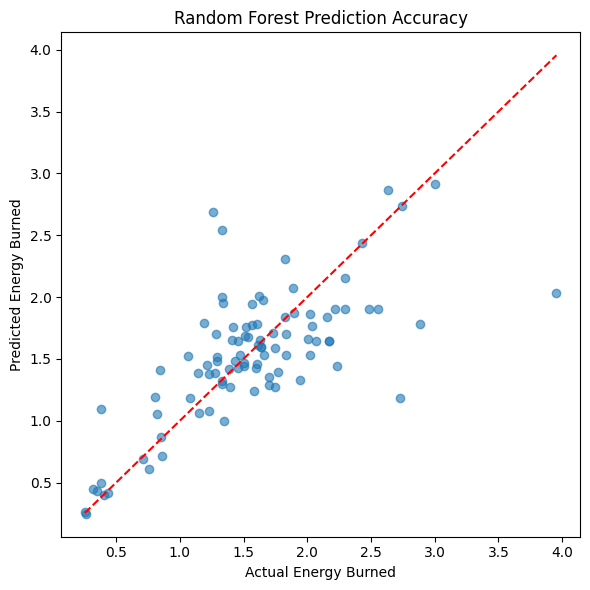

In [36]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Energy Burned')
plt.ylabel('Predicted Energy Burned')
plt.title('Random Forest Prediction Accuracy')
plt.tight_layout()
plt.show()

##  Summary

This notebook explores personal health data exported from Apple Health. **Please note that this analysis is performed using personal data, and if you wish to use this notebook, you can upload your own Apple Health data export.**

The analysis covers the following key areas:

1.  **Data Loading and Initial Inspection**: The raw data from the XML export was loaded into a pandas DataFrame, and an initial inspection of the data structure, columns, and data types was performed.
2.  **Data Cleaning and Preprocessing**: Steps were taken to clean the data, including converting date columns to datetime objects, converting numeric values, handling missing data, and removing duplicates.
3.  **Sleep Data Analysis**: Although part of a previous project, the notebook includes sections for analyzing sleep data, including sleep duration and heart rate during sleep.
4.  **Exploring Other Health Data**: Various other health data types were explored, with a focus on Heart Rate (`HKQuantityTypeIdentifierHeartRate`) and Physical Effort (`HKQuantityTypeIdentifierPhysicalEffort`).
5.  **Exploratory Data Analysis (EDA)**: Visualizations were created to understand the distribution of heart rate and sleep duration, and the relationship between heart rate and physical effort.
6.  **Correlation Analysis**: A correlation matrix of daily health metrics was generated to identify relationships between different data types.
7.  **Model Building**: An initial attempt was made to build a linear regression and a Random Forest model to predict Active Energy Burned based on other activity metrics. An attempt to predict sleep duration highlighted the need for a suitable target variable.

The notebook provides a comprehensive overview of the initial data processing, exploration, and some preliminary modeling using the Apple Health data.

## Save cleaned CSV file for future modelling

In [37]:
# Save the cleaned daily aggregated data to a CSV file
daily_df.to_csv('cleaned_daily_health_data.csv', index=True)
print("Cleaned data saved to 'cleaned_daily_health_data.csv'")

Cleaned data saved to 'cleaned_daily_health_data.csv'


In [38]:
# Save the merged heart rate and physical effort data
merged.to_csv('merged_heart_rate_physical_effort.csv', index=True)
print("Merged heart rate and physical effort data saved to 'merged_heart_rate_physical_effort.csv'")

Merged heart rate and physical effort data saved to 'merged_heart_rate_physical_effort.csv'


In [39]:
# Save the sleep session data
sleep_df.to_csv('sleep_sessions.csv', index=False)
print("Sleep session data saved to 'sleep_sessions.csv'")

Sleep session data saved to 'sleep_sessions.csv'


In [40]:
# Save the sleep heart rate data
sleep_hr_df.to_csv('sleep_heart_rate_data.csv', index=True)
print("Sleep heart rate data saved to 'sleep_heart_rate_data.csv'")

Sleep heart rate data saved to 'sleep_heart_rate_data.csv'


In [41]:
# Save the generally cleaned DataFrame
df.to_csv('generally_cleaned_health_data.csv', index=False)
print("Generally cleaned data saved to 'generally_cleaned_health_data.csv'")

Generally cleaned data saved to 'generally_cleaned_health_data.csv'


### Summary of Saved CSV Files

Here is a summary of the CSV files we have saved from this notebook for your future use:

*   **`cleaned_daily_health_data.csv`**: Contains daily aggregated health metrics, useful for analyzing trends and building models on a daily level.
*   **`merged_heart_rate_physical_effort.csv`**: Contains heart rate and physical effort data merged at a minute-by-minute frequency, suitable for granular time-series analysis and modeling of the relationship between heart rate and physical effort.
*   **`sleep_sessions.csv`**: Contains individual sleep session data with duration, useful for analyzing sleep patterns and modeling sleep-specific outcomes.
*   **`sleep_heart_rate_data.csv`**: Contains heart rate measurements recorded specifically during sleep sessions, valuable for detailed analysis and modeling of sleep heart rate patterns.
*   **`generally_cleaned_health_data.csv`**: Contains all health data after initial general cleaning, providing a comprehensive dataset for exploring various factors and preparing data for different modeling tasks.